In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import feature_selection_helpers as fsh
import NSCH_helpers as nh
import model_selection_helpers as mh
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [4]:
#Read in data
df = pd.read_sas('data/nsch_2019e_topical.sas7bdat')

#Clean data
df_clean = nh.clean_NSCH(df, response = 'K7Q02R_R',
               dropna_response = True,
               drop_notenrolled = True, 
               remove_sparse = False, 
               remove_unexpected = False,
               replace_with = 0,               
               state = 'both')

#manually drop features we agreed to drop until we remove them from the CSV file
agreed_to_drop = ['a1_mental_health', 'a1_physical_health', 'a2_mental_health', 'a2_physical_health', 'costs_issue', 'is_native', 'is_asian', 'is_hispanic',
                             'is_hawaiian', 'birth_year', 'saw_nonmental_specialist', 'num_checkups']
#manually drop features that highly correlate with other model features 
high_corr_to_drop = ['transportation','not_open','not_eligible','appointment_problems','insurance_cost_issue','not_recieved_healthcare', 'insurance_type',
           'how_covered','how_insured', 'indian_health_services','currently_covered']

cols_to_drop = [x for x in agreed_to_drop+high_corr_to_drop if x in df_clean.columns]
df_clean = df_clean.drop(columns=cols_to_drop)

In [5]:
## Note: this cell might take 2-3 minutes to run

#Split data into features and target
X = df_clean.drop(columns=['days_missed']).select_dtypes(include=['number']).copy()
y = df_clean['days_missed'].copy()

#Convert days_missed into a categorical variable: 0 means 0-6 days missed, 1 means 7+ days missed
y = y.mask(y<=3,0).mask(y>3,1)

#train test split and impute missing data. This will take ~3 minutes if imputer='rf'.
X_train, X_test, y_train, y_test = mh.split_impute(X, y, test_size=0.2, imputer = 'rf',has_response = False,test_has_response = False)

#remove the state feature (the only non-numerical feature). Store it in X_train_states and X_test_states in case we need it later
X_train_states = X_train.pop('ABBR')
X_test_states = X_test.pop('ABBR')

In [6]:
## Fit a logistic regression model to our data
#Hyperparamater C=0.5 chosen using GridSearchCV() (not shown here)
lr = LogisticRegression(max_iter=10000, C=0.5, tol=1e-6, random_state=42)
lr.fit(X_train, y_train)

LogisticRegression(C=0.5, max_iter=10000, random_state=42, tol=1e-06)

<Axes: ylabel='Feature'>

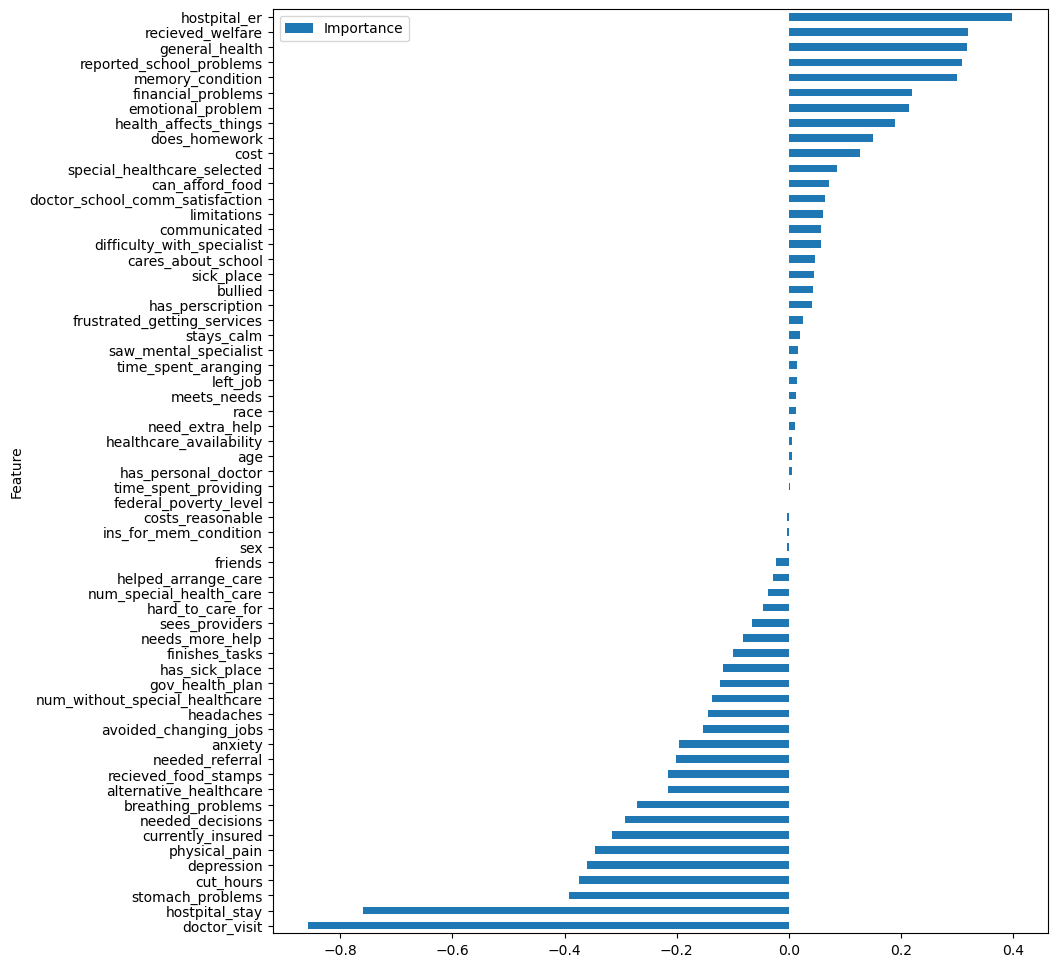

In [7]:
## Visualize feature importance by plotting the fitted model coefficients
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': lr.coef_[0]}).sort_values('Importance')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 12))

**Many of these features do not seem to influence the model much. Next, we'll iteratively remove the feature with the smallest coefficient (in magnitude) until model performance starts to suffer. We'll do this using [sklearn's RFE function](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html)**

In [8]:
from sklearn.feature_selection import RFE

In [20]:
## For the sake of comparison with the results below, let's compute the average precision score of the model with all features:

print('The average precision score on the test set with all ' + str(len(X_train.columns)) + ' features is ' + str(average_precision_score(y_test, lr.predict_proba(X_test)[:,1])) + '.')

The average precision score on the test set with all 61 features is 0.42352262496485665.


In [30]:
num_to_keep = [25, 20, 15, 10] #number of features to keep

features = []
clfs = []
for num in num_to_keep:
    lr_rfe = LogisticRegression(max_iter=10000, C=0.5, tol=1e-6, random_state=42)

    #Run RFE to pick out the num most important features
    rfe = RFE(lr_rfe, n_features_to_select=num, step=1)
    rfe = rfe.fit(X_train, y_train)

    X_train_rfe = rfe.transform(X_train)
    X_test_rfe = rfe.transform(X_test)
    lr_rfe.fit(X_train_rfe, y_train)
    y_train_probs = lr_rfe.predict_proba(X_train_rfe)
    y_test_probs = lr_rfe.predict_proba(X_test_rfe)

    features.append(list(np.array(X_train.columns)[rfe.support_]))
    clfs.append(lr_rfe)

    print('The average precision score on the test set while keeping ' + str(num) + ' features is ' + str(average_precision_score(y_test, y_test_probs[:,1])) + '.')


The average precision score on the test set while keeping 25 features is 0.42185069455482616.
The average precision score on the test set while keeping 20 features is 0.41692541715139575.
The average precision score on the test set while keeping 15 features is 0.41426164940946525.
The average precision score on the test set while keeping 10 features is 0.4079551492111875.


**The average precision with 25 features is nearly identical to the average precision of the model will all 61 features. Performace dips from there, though there is not much difference between the model with 20 and the model with 15 features. Let's look at what features we keep in each case.**

In [29]:
for i in range(len(num_to_keep)):
    print('The ' + str(num_to_keep[i]) + ' most important features are ')
    features[i].sort()
    print(features[i])
    print('\n')

The 25 most important features are 
['alternative_healthcare', 'anxiety', 'avoided_changing_jobs', 'breathing_problems', 'cut_hours', 'depression', 'doctor_visit', 'does_homework', 'emotional_problem', 'financial_problems', 'general_health', 'has_sick_place', 'headaches', 'health_affects_things', 'hostpital_er', 'hostpital_stay', 'memory_condition', 'needed_decisions', 'needed_referral', 'num_without_special_healthcare', 'physical_pain', 'recieved_food_stamps', 'recieved_welfare', 'reported_school_problems', 'stomach_problems']


The 20 most important features are 
['alternative_healthcare', 'anxiety', 'avoided_changing_jobs', 'breathing_problems', 'cut_hours', 'depression', 'doctor_visit', 'emotional_problem', 'financial_problems', 'general_health', 'health_affects_things', 'hostpital_er', 'hostpital_stay', 'memory_condition', 'needed_decisions', 'needed_referral', 'physical_pain', 'recieved_welfare', 'reported_school_problems', 'stomach_problems']


The 15 most important features are

**We can visualize the importance of each feature in each model by plotting the size of each coefficient in a bar graph:**

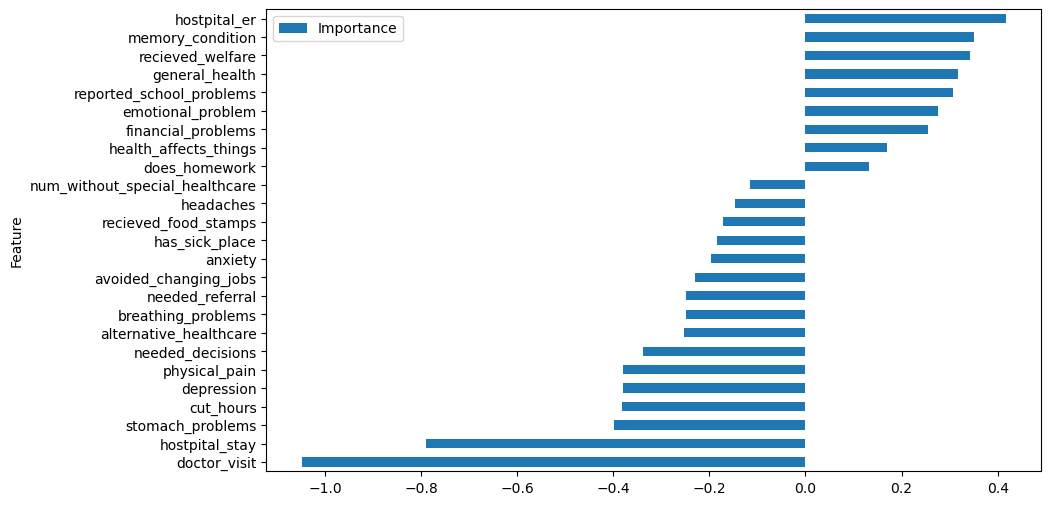

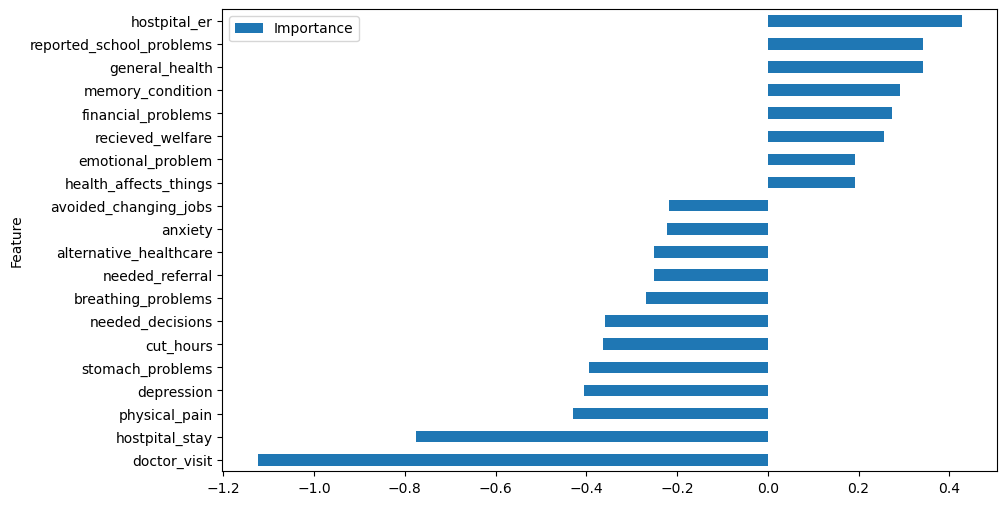

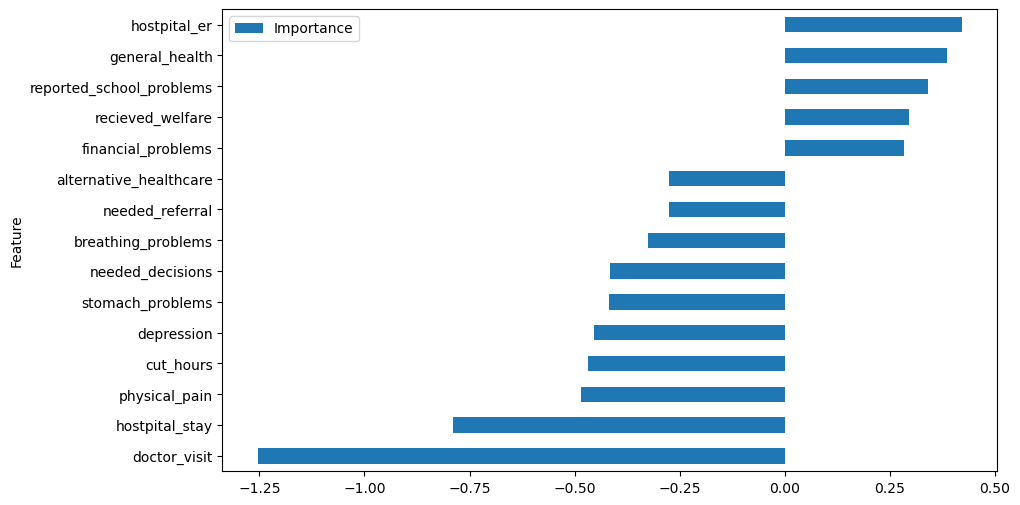

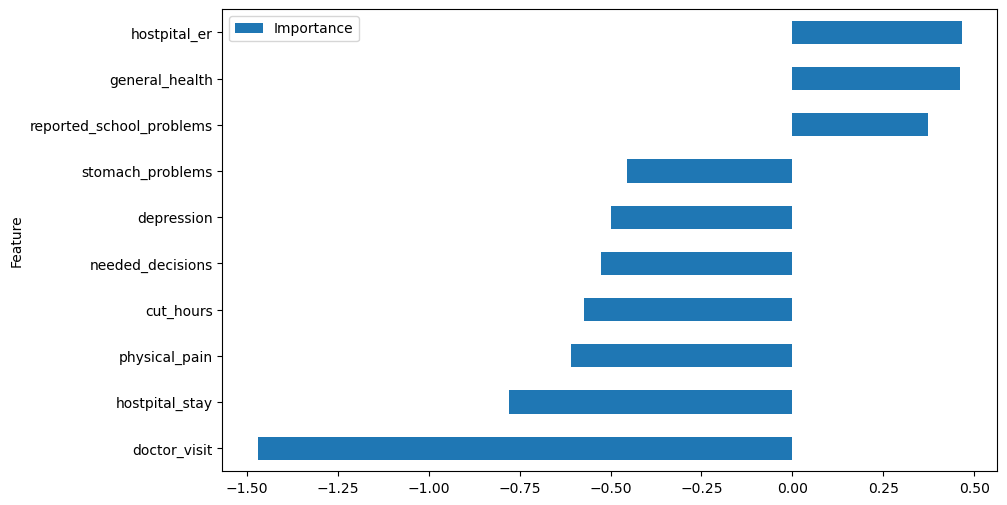

In [35]:
for i in range(len(num_to_keep)):
    # Visualize feature importance by plotting the fitted model coefficients
    feature_importance = pd.DataFrame({'Feature': features[i], 'Importance': clfs[i].coef_[0]}).sort_values('Importance')
    feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

**We can similarly visualize odds ratios. Odds ratios tell us the relative increase in the odds that a student will have high absenteeism due to a unit increase in the given feature**

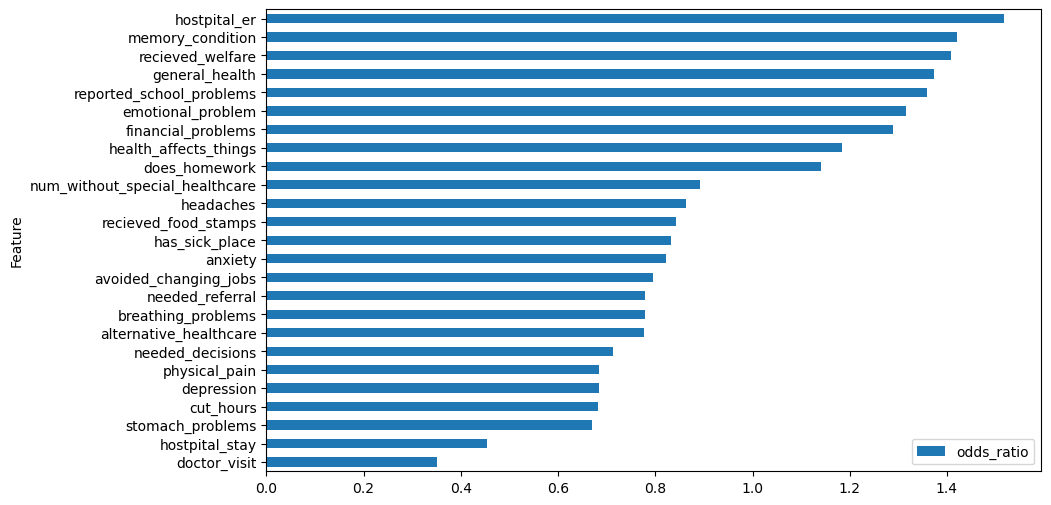

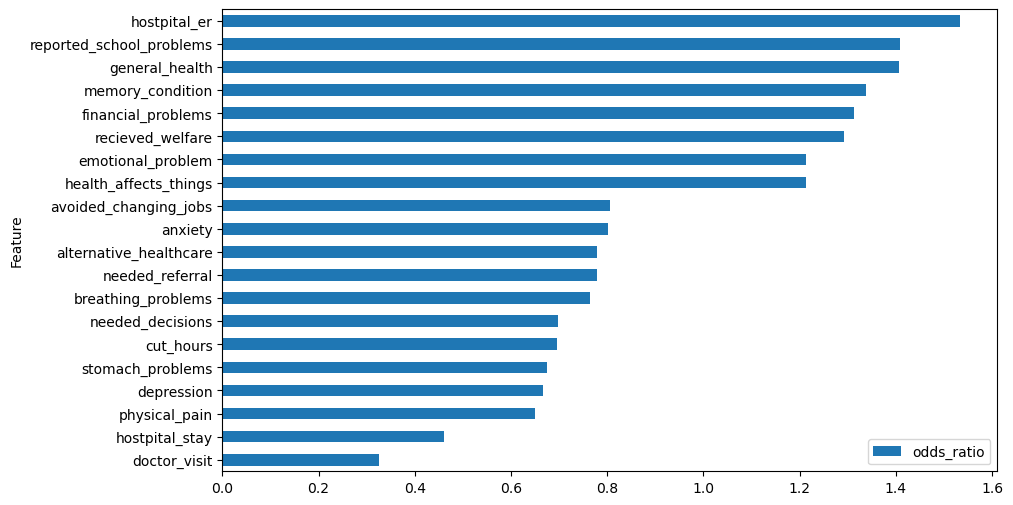

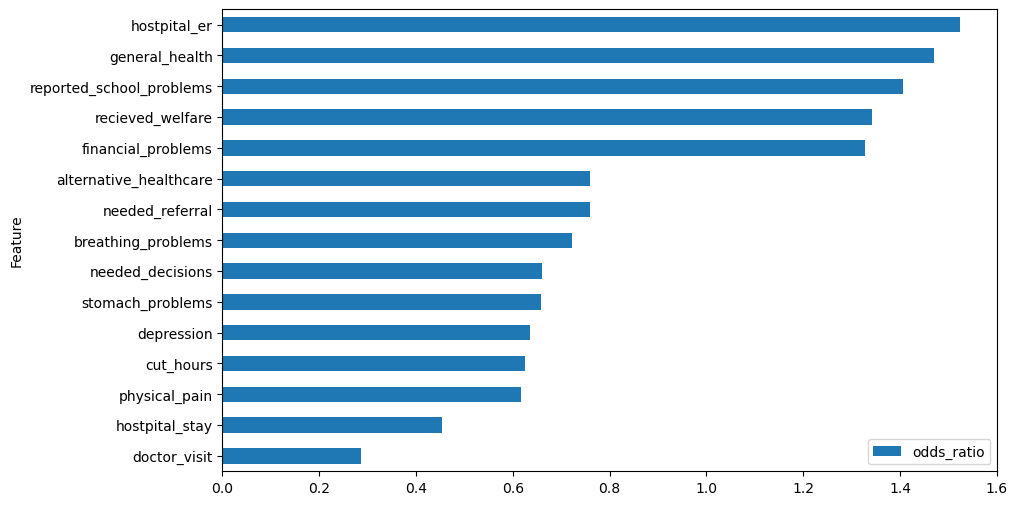

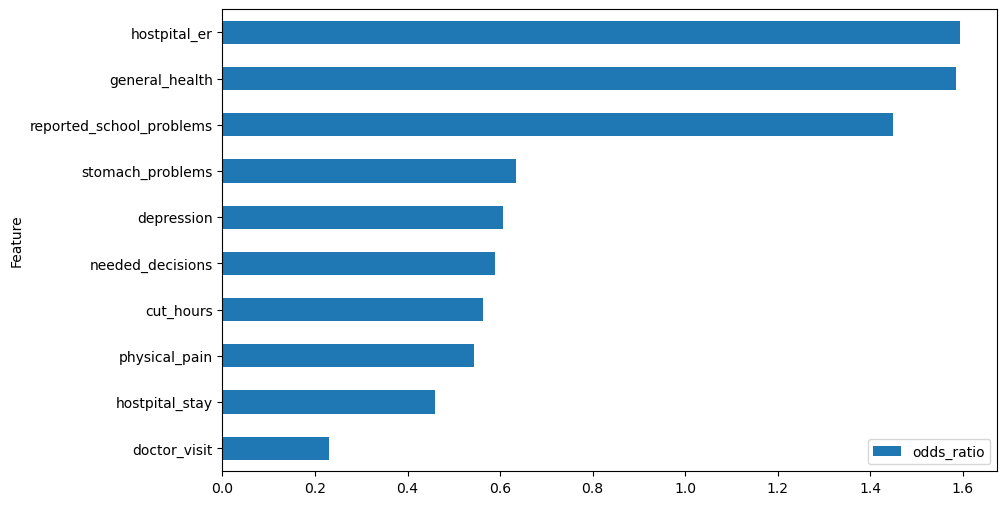

In [36]:
for i in range(len(num_to_keep)):
    # Visualize feature importance by plotting the fitted model coefficients
    feature_importance = pd.DataFrame({'Feature': features[i], 'Importance': clfs[i].coef_[0]}).sort_values('Importance')
    feature_importance['odds_ratio'] = feature_importance['Importance'].apply(np.exp)
    feature_importance.plot(x='Feature', y='odds_ratio', kind='barh', figsize=(10, 6)) 